In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from shutil import copyfile
from keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from sklearn.model_selection import GridSearchCV



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the data,clean, transform

In [ ]:
data_dir = "/content/drive/MyDrive/ML/data/"

data = []
labels = []

# Create Directory for two classes
for label in  ["NoSunglasses/","Sunglassess/"]:
  full_path = os.path.join(data_dir, label)
  for image in os.listdir(full_path): 
    full_path_img = os.path.join(full_path, image) 
    img = cv2.imread(full_path_img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (64, 64))
    data.append(resized_img)
    if 'NoSunglasses' in str(full_path_img):
      labels.append(0)
    else:
      labels.append(1)

# reshape and normalize the data
X = np.array(data)
X = X.reshape(-1, 64, 64, 1)
X = normalize(X, axis=1)
y = to_categorical(labels)


##train/validation/test split

In [ ]:
# Split to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the testing set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# #Our CNN model
def create_model(optimizer='rmsprop'):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

#Example of train model

In [ ]:
# Create and training Our model
model = create_model()
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val), verbose=0)

3/3 - 0s - loss: 0.1361 - accuracy: 0.9468 - 145ms/epoch - 48ms/step


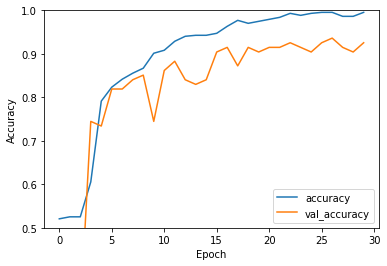

In [ ]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

#Grid Search

In [ ]:
# That the parms that we will check who are the best
params = {
'epochs': [10,20,30],
'optimizer': ['adam','sgd','rmsprop'],
"batch_size": [16, 32, 64]}

# Apply grid search
model = KerasClassifier(build_fn=create_model, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=params, cv=2)
grid_result = grid.fit(X_train, y_train,validation_data=(X_val, y_val))

<ipython-input-146-ad969c1dfa5c>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.922018 using {'batch_size': 16, 'epochs': 30, 'optimizer': 'rmsprop'}


The Best Model

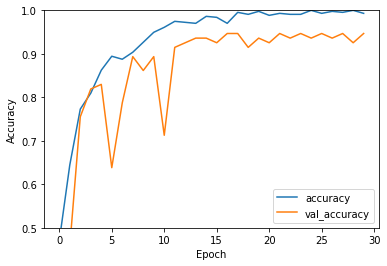

In [ ]:
best_model = create_model(grid_result.best_params_['optimizer'])
history_best_model = best_model.fit(X_train, y_train, batch_size=grid_result.best_params_['batch_size'] ,epochs=grid_result.best_params_['epochs'], 
                    validation_data=(X_val, y_val),verbose=0)

plt.plot(history_best_model.history['accuracy'], label='accuracy')
plt.plot(history_best_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = best_model.evaluate(X_test,  y_test, verbose=0)

Answer the next questions:
1. Does the model overfit?
2. What's the effect of batch size? In general, do you see this effect in the current task?
3. What was the optimal optimizer? Explain.

1. Does the model overfit?

In [ ]:
test_loss, train_acc = best_model.evaluate(X_train,  y_train, verbose=2)
print(f"accuracy Train:{train_acc}")
test_loss, test_acc = best_model.evaluate(X_test,  y_test, verbose=2)
print(f"accuracy Test:{test_acc}")

14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - 637ms/epoch - 45ms/step
accuracy Train:1.0
3/3 - 0s - loss: 0.1756 - accuracy: 0.9681 - 148ms/epoch - 49ms/step
accuracy Test:0.9680851101875305


In [ ]:
model = KerasClassifier(build_fn=create_model,batch_size=grid_result.best_params_['batch_size'] ,epochs=grid_result.best_params_['epochs'],verbose = 0)
scores = cross_val_score(model, X_train, y_train, cv=4)
print("Cross validation accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

<ipython-input-152-4375c297cc06>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,batch_size=grid_result.best_params_['batch_size'] ,epochs=grid_result.best_params_['epochs'],verbose = 0)


Cross validation accuracy: 97.02% (1.36%)


Based on the results Acuuracy Train 100% and Acuuracy Test of 96%, because the accuracy of the train is 100% this shows that there is a little overfitting, but the performance on the test is high(a small gap between the train to test set),so it can be said that there is no overfitting.
In the cross validation, it can be seen that the accuracy of the model has decreased slightly and close to the test accuracy.
And so you can say that there are almost none overfitting.


2.What's the effect of batch size? In general, do you see this effect in the current task?

Batch size is a hyperparameter that refers to the number of samples used in one iteration of training. In other words, it determines the number of samples that are processed by the model before the weights are updated. 
During training, the model's parameters are updated after each batch of data is processed.

The batch size can have a significant impact on the training process. A larger batch size can lead to a more stable gradient and faster training, as it makes better use of hardware such as GPU, but can lead to overfitting. On the other hand, a smaller batch size may take longer to train but may be more memory efficient, as it allows for more frequent weight updates, which can help the model converge faster and result in a better generalization performance but which can introduce noise to model.

In our task, we tested various batch sizes in order to find the optimal setting for our model and dataset. We tried batch sizes of 16, 32, 64 and found that the smallest batch size of 16 led to the best performance.
This smaller batch size added noise to the training process, which helped to prevent overfitting.
Our results indicate that a batch size of 16 is the optimal setting for this task.




3.What was the optimal optimizer? Explain

There could be several reasons why RMSprop was determined to be the best optimizer in our grid search.
One possibility is that it is particularly well-suited to the specific architecture and dataset you were working with.
RMSprop is an adaptive learning rate optimization algorithm, which means that it automatically adjusts the learning rate of the model during training. 
This can help the model converge faster and avoid getting stuck in local minima.
Additionally, RMSprop is designed to work well with neural networks, which  type of our model you were use.